<a href="https://colab.research.google.com/github/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Đồ án Lập trình song song ứng dụng**

# Xoá background dựa trên ứng dụng segmentation của SLIC

## Giáo viên: Trần Trung Kiên

### Sinh viên:
- 1712568	KIM ĐÌNH LỘC	
- 1712787	NGUYỄN VĂN THÌN	
- 1712898	TRẦN VIỆT VĂN	


#1 MÔ TẢ ỨNG DỤNG

**Ứng dụng mà nhóm chọn là Xoá background dựa trên ứng dụng segmentation của SLIC**.  
- Input: Một tấm ảnh RGB, chỉ định vị trí object cần giữ lại (nếu có)


- Output: Ảnh đầu vào được xác định object và đã được segmentation

- Ý nghĩa của ứng dụng trong thực tế:
  - Hỗ trợ tách/lọc nền trong việc chỉnh sửa ảnh.
  - Là bước quan trọng trong các hệ thống sử dụng nhận diện vật thể.
  - Ứng dụng có thể tự động gắn tag/phân loại vật thể trong việc xử lý ảnh.
  - Tiết kiệm dung lượng lưu trữ.
- Lý do cần tăng tốc ứng dụng:
	- Ứng dụng sẽ chạy chậm nếu cài đặt tuần tự
	- Nhu cầu xử lý dữ liệu lớn, ảnh có độ phân giải cao hay việc xử lý theo thời gian thực
- Tiềm năng song song hóa của ứng dụng: 
  - Song song hoá việc chuyển từ hệ màu RGB sang hệ màu CELAB
  - Thực hiện đồng thời quá trình khởi tạo các cụm của SLIC.
  - Thực hiện đồng thời quá trình tính từ trung tâm cụm đến từng pixel trong vùng
  - Thực hiện đồng thời quá trình tích chập để tạo ra đường viền của từng vật thể
  - Song song hoá việc xử lý gộp ảnh segmentation và ảnh đường viền sang ảnh output.
- Thách thức:
  - Quá trình song song hoá việc kết nối các pixel trong SLIC có thể là một việc khó khăn. Nếu chúng ta giải quyết được phần đó sẽ có thể thực hiện tốt hơn vấn đề đặt ra.

#2. Cài đặt tuần tự

#2.1 Thiết kế mô hình

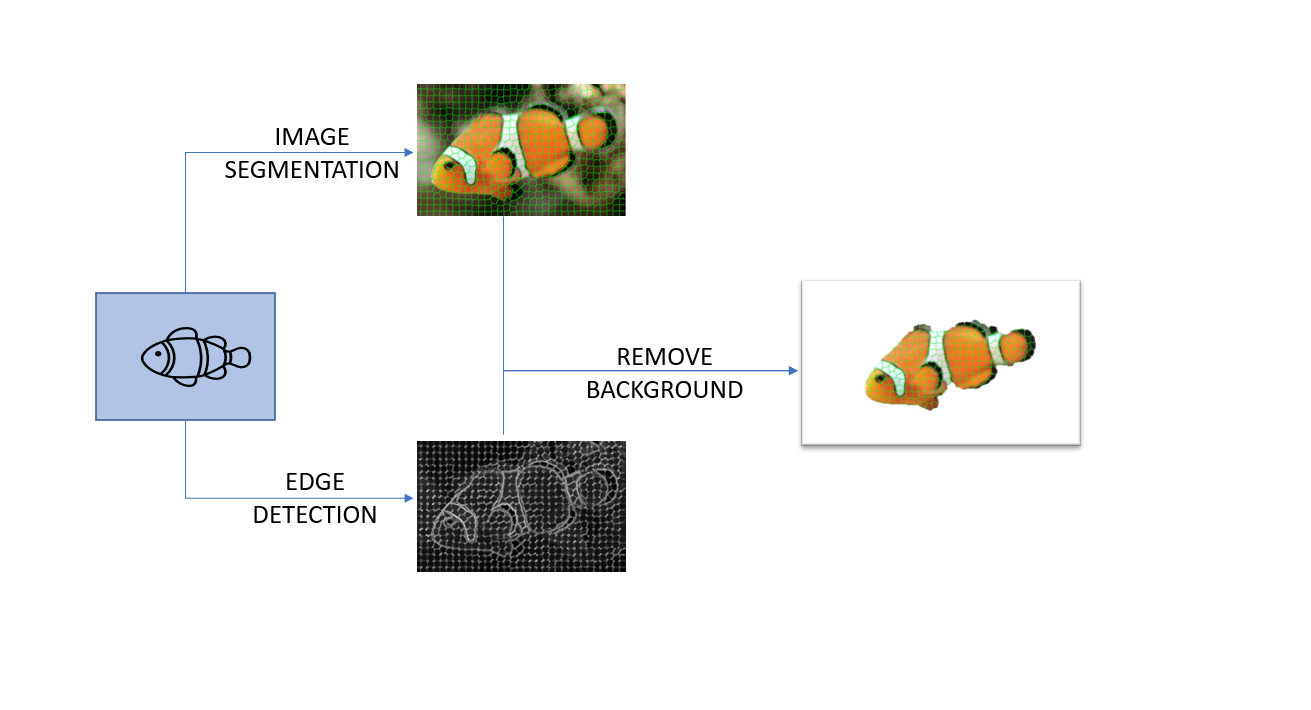